In [1]:
# Cell 0: Install necessary libraries
%pip install pandas matplotlib seaborn vaderSentiment scikit-learn nltk

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 5.9 MB/s  0:00:00

   ------------- -------------------------- 1/3 [click]
   ------------- -------------------------- 1/3 [click]
   -------------------------- ------------- 2/3 [nltk]
   -------------------------- ------------- 2/3 [nltk]
   -------------------------- ------------- 2/3 [nltk]
   -------------------------- ------------- 2/3 [nltk]
   -------------------------- ------------- 2/3 [nltk]
   -------------------------- ------------- 2/3 [nltk]
   -------------------------- ------------- 2/3 [nltk]
   -------------------------- ------------- 2/3 [nltk]
   -------------------------- ------------- 2/3 [nltk]
   -------------------------- ------------- 2/3 [nltk]
   -------------------------- ------------- 2/3 [nltk]
   -------------------------- ------------- 2/3 [nltk]
   -------------


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Cell 1: Load Data from Database

import sqlite3
import pandas as pd
import os

# --- Database Connection ---
db_relative_path = os.path.join('..', 'data', 'licensing_data.db')
db_path = os.path.abspath(db_relative_path)
print(f"Attempting to connect to database at: {db_path}")

conn = None # Initialize conn
try:
    conn = sqlite3.connect(db_path)
    print("Database connection successful!")
except Exception as e:
    print(f"ERROR: Could not connect to database: {e}")
    # Stop execution if DB connection fails
    raise SystemExit("Database connection failed, cannot proceed.") from e

# --- Load Data into Pandas DataFrames ---
print("\nLoading data into DataFrames...")
try:
    # Load Tweets (using correct table name 'tweets')
    df_tweets_raw = pd.read_sql_query("SELECT * FROM tweets", conn)
    print(f"Loaded {len(df_tweets_raw)} raw tweets.")
    
    # Load Products (joining with brands table)
    # Using LEFT JOIN to keep products even if brand_id is somehow missing in brands table
    df_products_raw = pd.read_sql_query("""
        SELECT 
            p.*, 
            b.brand_name AS brand_name_from_join 
        FROM products p 
        LEFT JOIN brands b ON p.brand_id = b.id
    """, conn)
    # Use the brand_name from the join, handle potential nulls if join failed
    df_products_raw['brand_name'] = df_products_raw['brand_name_from_join']
    df_products_raw.drop(columns=['brand_name_from_join'], inplace=True) 
    print(f"Loaded {len(df_products_raw)} raw products.")
    
    # Close the connection
    conn.close()
    print("\nDatabase connection closed.")
    
    # --- Initial Data Inspection ---
    print("\n--- Raw Tweet Data Sample ---")
    # Display more info to confirm fields are loaded
    print(df_tweets_raw[['brand_name', 'tweet_date', 'tweet_content', 'like_count', 'retweet_count']].head())
    print("\n--- Raw Tweet Data Info ---")
    df_tweets_raw.info()

    print("\n--- Raw Product Data Sample ---")
    print(df_products_raw[['brand_name', 'product_name', 'price', 'avg_rating', 'num_reviews']].head())
    print("\n--- Raw Product Data Info ---")
    df_products_raw.info()

except Exception as e:
    print(f"ERROR: Error loading data from database: {e}")
    if conn:
        conn.close()
        print("Database connection closed due to error.")
    raise SystemExit("Data loading failed.") from e # Stop if loading fails

Attempting to connect to database at: c:\Users\Nayef Alam\Desktop\ksa_licensing_model\data\licensing_data.db
Database connection successful!

Loading data into DataFrames...
Loaded 17386 raw tweets.
Loaded 1020 raw products.

Database connection closed.

--- Raw Tweet Data Sample ---
  brand_name                      tweet_date  \
0    Almarai  Thu Oct 23 09:27:43 +0000 2025   
1    Almarai  Thu Oct 23 07:35:39 +0000 2025   
2    Almarai  Tue Oct 21 11:23:38 +0000 2025   
3    Almarai  Mon Oct 20 18:22:12 +0000 2025   
4    Almarai  Sun Oct 19 16:16:23 +0000 2025   

                                       tweet_content  like_count  \
0  Almarai Jobs in Dammam Jobs in Saudi Arabia\n\...           0   
1  Are you ready to take your career to new heigh...           0   
2  what next, selling our land to other countries...           0   
3  @m_almuhaidib @almarai I have dates, Saudi cof...           1   
4  @Almarai_Care Asslam walaikum, I request to al...           0   

   retweet_count 

In [3]:
# Cell 2: Data Cleaning & Preprocessing

import numpy as np
import re
import pandas as pd # Ensure pandas is imported

print("--- Data Cleaning and Preprocessing ---")

# --- Clean df_tweets ---
print("\nCleaning Tweet Data...")

# Make a copy to avoid SettingWithCopyWarning
df_tweets = df_tweets_raw.copy()

if not df_tweets.empty:

    original_tweet_count = len(df_tweets)
    print(f"   Starting with {original_tweet_count} tweets.")

    # --- FIX: Parse Tweet Dates using the CORRECT format ---
    # The format from the JSON file looks like: 'Mon Oct 20 16:41:09 +0000 2025'
    # This corresponds to the format string: '%a %b %d %H:%M:%S +0000 %Y'
    date_format_string = '%a %b %d %H:%M:%S +0000 %Y' 
    print(f"   Attempting to parse dates using format: '{date_format_string}'...")
    
    parsed_dates = pd.to_datetime(df_tweets['tweet_date'], format=date_format_string, errors='coerce')

    df_tweets['tweet_date'] = parsed_dates
    
    # --- Drop rows with NaT dates ---
    parsed_count = df_tweets['tweet_date'].notna().sum()
    if parsed_count < original_tweet_count:
        print(f"   WARNING: {original_tweet_count - parsed_count} date formats could not be parsed even with explicit format.")
        # Print first few failed *original* strings for diagnosis
        failed_indices = df_tweets[df_tweets['tweet_date'].isna()].index
        print("   First 5 failing original date strings:")
        # Re-access original raw data for failed indices
        print(df_tweets_raw.loc[failed_indices, 'tweet_date'].head()) 
        
        df_tweets.dropna(subset=['tweet_date'], inplace=True)
        print(f"   Dropped invalid date rows. Remaining tweets: {len(df_tweets)}")
    else:
        print("   All tweet dates parsed successfully.")

    # Ensure numeric columns are numeric (using correct names)
    numeric_tweet_cols = ['reply_count', 'retweet_count', 'like_count', 'quote_count']
    for col in numeric_tweet_cols:
        df_tweets[col] = pd.to_numeric(df_tweets[col], errors='coerce').fillna(0).astype(int)

    # Basic text cleaning function 
    def clean_text(text): 
        if isinstance(text, str):
            text = re.sub(r'http\S+', '', text) # Remove URLs
            # Keep basic punctuation, remove others. Keep Arabic.
            text = re.sub(r'[^\w\s.,!?-_\u0600-\u06FF]+', '', text) 
            text = text.lower().strip()
        # Return empty string if input wasn't a string (handles potential None/NaN)
        return text if isinstance(text, str) else '' 

    # Apply cleaning to 'tweet_content'
    print("   Applying basic cleaning to tweet_content...")
    df_tweets['cleaned_content'] = df_tweets['tweet_content'].apply(clean_text)

    print("Tweet Data Cleaned:")
    if not df_tweets.empty:
        df_tweets.info() 
    else:
        print("   DataFrame became empty after dropping rows with unparseable dates.")

else:
    print("   WARNING: Raw tweet DataFrame is empty. Skipping tweet cleaning.")

# --- Clean df_products ---
print("\nCleaning Product Data...")

# Make a copy
df_products = df_products_raw.copy()

if not df_products.empty:
    # Ensure numeric columns are numeric
    numeric_product_cols = ['price', 'avg_rating', 'num_reviews']
    for col in numeric_product_cols:
        df_products[col] = pd.to_numeric(df_products[col], errors='coerce')
        
    # Fill missing ratings and review counts with 0
    df_products['avg_rating'] = df_products['avg_rating'].fillna(0)
    # Ensure num_reviews is integer after filling
    df_products['num_reviews'] = df_products['num_reviews'].fillna(0).astype(int) 
    
    print("Product Data Cleaned:")
    df_products.info()
else:
    print("   Raw product DataFrame is empty. Skipping product cleaning.")

print("\n--- Cleaning Complete ---")

--- Data Cleaning and Preprocessing ---

Cleaning Tweet Data...
   Starting with 17386 tweets.
   Attempting to parse dates using format: '%a %b %d %H:%M:%S +0000 %Y'...
   All tweet dates parsed successfully.
   Applying basic cleaning to tweet_content...
Tweet Data Cleaned:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17386 entries, 0 to 17385
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               17386 non-null  int64         
 1   brand_name       17386 non-null  object        
 2   tweet_id         17386 non-null  object        
 3   tweet_date       17386 non-null  datetime64[ns]
 4   username         17386 non-null  object        
 5   tweet_content    17386 non-null  object        
 6   language         17386 non-null  object        
 7   reply_count      17386 non-null  int64         
 8   retweet_count    17386 non-null  int64         
 9   like_count       17386 non

In [5]:
# Cell 3: Feature Engineering (Tweet Volume, Product Metrics)

import numpy as np
import pandas as pd # Ensure pandas is imported

print("--- Feature Engineering ---")

# --- Calculate Tweet Volume per Brand ---
print("\nCalculating Tweet Volume per Brand...")

# Check if df_tweets exists and has data
if 'df_tweets' in locals() and not df_tweets.empty and 'brand_name' in df_tweets.columns:
    # Group tweets by brand and count them
    df_tweet_volume = df_tweets.groupby('brand_name').size().reset_index(name='tweet_volume')

    print("   Created 'df_tweet_volume' DataFrame.")
    print(df_tweet_volume.head())
else:
     print("   WARNING: Cannot calculate tweet volume. df_tweets is empty or missing 'brand_name'.")
     df_tweet_volume = pd.DataFrame(columns=['brand_name', 'tweet_volume'])


# --- Calculate Brand Metrics from Products ---
print("\nCalculating Brand Metrics from Product Data...")
if 'df_products' in locals() and not df_products.empty:
    if 'brand_name' in df_products.columns and 'product_name' in df_products.columns and \
       'avg_rating' in df_products.columns and 'num_reviews' in df_products.columns:

        df_brand_metrics = df_products.groupby('brand_name').agg(
            market_saturation=('product_name', 'count'),
            avg_perceived_quality=('avg_rating', 'mean'),
            avg_num_reviews=('num_reviews', 'mean')
        ).reset_index()
        # Round the averages for cleaner display
        df_brand_metrics['avg_perceived_quality'] = df_brand_metrics['avg_perceived_quality'].round(2)
        df_brand_metrics['avg_num_reviews'] = df_brand_metrics['avg_num_reviews'].round(2)
        print("   Created 'df_brand_metrics' DataFrame.")
        print(df_brand_metrics.head())
    else:
        print("   ERROR: Required columns missing in df_products. Cannot calculate brand metrics.")
        print("   Columns found:", df_products.columns)
        df_brand_metrics = pd.DataFrame(columns=['brand_name', 'market_saturation', 'avg_perceived_quality', 'avg_num_reviews'])
else:
    print("   Product DataFrame is empty or does not exist, skipping brand metrics calculation.")
    df_brand_metrics = pd.DataFrame(columns=['brand_name', 'market_saturation', 'avg_perceived_quality', 'avg_num_reviews'])

# --- Combine Metrics into One DataFrame ---
print("\nCombining all metrics...")

# Ensure both dataframes exist before merging
if 'df_tweet_volume' in locals() and 'df_brand_metrics' in locals():
    # Merge tweet volume with product metrics using brand_name
    df_combined_metrics = pd.merge(df_tweet_volume, df_brand_metrics, on='brand_name', how='outer')

    # Fill NaN values that result from the merge
    df_combined_metrics['tweet_volume'] = df_combined_metrics['tweet_volume'].fillna(0).astype(int)
    df_combined_metrics['market_saturation'] = df_combined_metrics['market_saturation'].fillna(0).astype(int)
    df_combined_metrics['avg_perceived_quality'] = df_combined_metrics['avg_perceived_quality'].fillna(0)
    df_combined_metrics['avg_num_reviews'] = df_combined_metrics['avg_num_reviews'].fillna(0)

    print("   Created 'df_combined_metrics' DataFrame.")
    print(df_combined_metrics.sort_values(by='tweet_volume', ascending=False).head()) # Show top by volume
else:
    print("   ERROR: Could not combine metrics because one or both required DataFrames are missing.")
    # Define df_combined_metrics as empty if merge fails, to prevent later errors
    df_combined_metrics = pd.DataFrame() 

print("\n--- Feature Engineering Complete ---")

--- Feature Engineering ---

Calculating Tweet Volume per Brand...
   Created 'df_tweet_volume' DataFrame.
                                          brand_name  tweet_volume
0  \n    # Copied from the log where errors start...           144
1                                               APOA             5
2                                             Abadia            38
3                             Abdul Samad Al Qurashi            44
4                                    Al Nakheel Mall           167

Calculating Brand Metrics from Product Data...
   Created 'df_brand_metrics' DataFrame.
               brand_name  market_saturation  avg_perceived_quality  \
0                    1886                 25                   3.58   
1                    APOA                  2                   0.00   
2                  Abadia                 25                   2.10   
3  Abdul Samad Al Qurashi                 25                   1.57   
4                Al Rabie                 25   

In [6]:
# Cell 3: Phase 3a - Tweet Sentiment Analysis

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd # Ensure pandas is imported

print("--- Phase 3a: Tweet Sentiment Analysis ---")

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get VADER sentiment score (compound score)
def get_vader_sentiment(text):
    if isinstance(text, str) and text.strip(): # Check if text is a non-empty string
        # Compound score: normalized, weighted composite score, -1 (most neg) to +1 (most pos)
        return analyzer.polarity_scores(text)['compound']
    return 0.0 # Return neutral score for empty strings or non-string data

# Check if df_tweets exists and has the cleaned content column
if 'df_tweets' in locals() and not df_tweets.empty and 'cleaned_content' in df_tweets.columns:
    print("\nCalculating sentiment scores for tweets using 'cleaned_content'...")
    
    # Apply the function to the 'cleaned_content' column
    df_tweets['sentiment_score'] = df_tweets['cleaned_content'].apply(get_vader_sentiment)
    
    print("   Added 'sentiment_score' column.")
    # Display sample results including the new score
    print("   Sample tweets with sentiment scores:")
    print(df_tweets[['brand_name', 'cleaned_content', 'sentiment_score']].sample(10)) # Show a random sample

    # --- Calculate Average Sentiment per Brand ---
    print("\nCalculating average sentiment per brand...")
    # Group by brand_name and calculate the mean of the sentiment scores
    df_avg_sentiment = df_tweets.groupby('brand_name')['sentiment_score'].mean().reset_index()
    df_avg_sentiment.rename(columns={'sentiment_score': 'avg_tweet_sentiment'}, inplace=True)
    df_avg_sentiment['avg_tweet_sentiment'] = df_avg_sentiment['avg_tweet_sentiment'].round(3) # Round for readability
    
    print("   Created 'df_avg_sentiment' DataFrame.")
    print("   Average Sentiment per Brand (Top 5 Positive):")
    print(df_avg_sentiment.sort_values(by='avg_tweet_sentiment', ascending=False).head())
    print("   Average Sentiment per Brand (Top 5 Negative/Neutral):")
    print(df_avg_sentiment.sort_values(by='avg_tweet_sentiment', ascending=True).head())


    # --- Merge Average Sentiment into Combined Metrics ---
    print("\nMerging average sentiment into combined metrics...")
    # Ensure df_combined_metrics exists from the previous cell
    if 'df_combined_metrics' in locals() and not df_combined_metrics.empty:
        # Merge, ensuring brand_name column exists in both
        if 'brand_name' in df_combined_metrics.columns and 'brand_name' in df_avg_sentiment.columns:
            df_combined_metrics = pd.merge(df_combined_metrics, df_avg_sentiment, on='brand_name', how='left')
            # Fill potential NaN if a brand had no tweets to analyze (shouldn't happen if df_tweets was used to create df_combined_metrics initially)
            df_combined_metrics['avg_tweet_sentiment'] = df_combined_metrics['avg_tweet_sentiment'].fillna(0.0) 
            
            print("   Updated 'df_combined_metrics' DataFrame:")
            # Display the updated combined metrics
            print(df_combined_metrics.head())
            print("\n   Checking data types of combined metrics:")
            df_combined_metrics.info()
        else:
            print("   ERROR: 'brand_name' column missing in one of the DataFrames. Cannot merge sentiment.")
            
    else:
        print("   ERROR: 'df_combined_metrics' not found from previous step. Cannot merge sentiment.")
        
else:
    print("   WARNING: df_tweets is empty or missing 'cleaned_content'. Cannot perform sentiment analysis.")

print("\n--- Sentiment Analysis Complete ---")

--- Phase 3a: Tweet Sentiment Analysis ---

Calculating sentiment scores for tweets using 'cleaned_content'...
   Added 'sentiment_score' column.
   Sample tweets with sentiment scores:
                   brand_name  \
15270                   eXtra   
645                   Almarai   
12477            Body Masters   
17088                  Qormuz   
7931              Arabian Oud   
1259   Saudia Dairy (SADAFCO)   
264                   Almarai   
3611        Al-Othaim Markets   
6181                    Goody   
2604                    NADEC   

                                         cleaned_content  sentiment_score  
15270  @kaskoolc ياهلا انتهت عروض اليوم الوطني بتاريخ...           0.0000  
645    @almarai ألف ألف مبروك تأهل منتخبنا الوطني إلى...           0.0000  
12477  نصيحة بودي_ماسترز \n\n4 tips to increase your ...           0.3802  
17088  صحيفة قرمز بحلّتها الجديدة تصدر غدًا!\n\nاشترك...           0.0000  
7931                      @arabian_oud العربيةللعودتهديك           0.0

In [8]:
# Cell 4 (Run Once): Download NLTK stopwords (Simplified)
import nltk
import ssl # Import ssl to handle potential certificate issues

try:
    # Disable SSL certificate verification (sometimes needed for nltk.download)
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass # Means it might not be needed or already handled
else:
    ssl._create_default_https_context = _create_unverified_https_context

print("Attempting to download NLTK stopwords...")
try:
    nltk.download('stopwords')
    print("NLTK stopwords downloaded successfully or already present.")
except Exception as e:
    print(f"ERROR: Could not download NLTK stopwords. Error: {e}")
    print("Please check your internet connection and try running this cell again.")
    # You might need to configure nltk data path manually if issues persist.

Attempting to download NLTK stopwords...


[nltk_data] Downloading package stopwords to C:\Users\Nayef
[nltk_data]     Alam\AppData\Roaming\nltk_data...


NLTK stopwords downloaded successfully or already present.


[nltk_data]   Unzipping corpora\stopwords.zip.


In [9]:
# Cell 5: Phase 3b - Topic Modeling with LDA

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
import re

print("--- Phase 3b: Topic Modeling (LDA) ---")

# --- Configuration ---
NUM_TOPICS = 5 # How many topics to try and find per brand
NUM_TOP_WORDS = 7 # How many top words to display for each topic

# --- Prepare Stopwords ---
# Combine English and Arabic stopwords (basic list, can be expanded)
stop_words_en = list(stopwords.words('english'))
# Basic Arabic stopwords (consider using a more comprehensive list if needed)
# Example source: https://github.com/mohataher/arabic-stop-words
stop_words_ar = ["من", "في", "على", "الى", "عن", "و", "يا", "اي", "ما", "هو", "هي", 
                 "هذا", "هذه", "ذلك", "تلك", "ان", "او", "كل", "لا", "لن", "لم", 
                 "تم", "قد", "مع", "به", "له", "فيه", "عليها", "اليها", "عنه", 
                 "ايضا", "كان", "يكون", "صلى", "عليه", "وسلم", "قال", "ص", "ع",
                 "ريال", "سعودي", "انا", "انت", "هم", "هن", "نحن", "اليوم", "جدا",
                 "الله", "بن", "تم", "اللي", "الي", "حتى", "التي", "الذي"] # Added common KSA terms
stop_words_combined = stop_words_en + stop_words_ar
# Add brand names to stopwords to avoid them dominating topics
if 'df_tweets' in locals() and not df_tweets.empty:
     brand_names_lower = [name.lower() for name in df_tweets['brand_name'].unique()]
     # Add variations if needed (e.g., alhilal, al-hilal)
     stop_words_combined.extend(brand_names_lower) 
     # Add common social media terms
     stop_words_combined.extend(['rt', 'amp', 'co', 'https', 'http'])

# --- Function to display topics ---
def display_topics(model, feature_names, num_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        topics[f"Topic {topic_idx+1}"] = ", ".join(top_words)
        print(f"Topic {topic_idx+1}: {', '.join(top_words)}")
    return topics

# --- Perform LDA for each Brand ---
brand_topics = {}

if 'df_tweets' in locals() and not df_tweets.empty and 'cleaned_content' in df_tweets.columns:
    print("\nProcessing topics for each brand...")
    # Group by brand
    for brand_name, group_df in df_tweets.groupby('brand_name'):
        print(f"\n--- Topics for: {brand_name} ---")
        
        # Filter out very short or empty tweets for better topic modeling
        texts = group_df['cleaned_content'][group_df['cleaned_content'].str.len() > 10].tolist() 
        
        if len(texts) < NUM_TOPICS: # Need enough documents for LDA
            print(f"   Skipping {brand_name}: Not enough tweets (found {len(texts)}) for LDA.")
            brand_topics[brand_name] = {"Error": "Not enough data"}
            continue

        try:
            # 1. Vectorize the text data using TF-IDF
            # max_df ignores terms that appear in >95% of docs (too common)
            # min_df ignores terms that appear in < 2 docs (too rare)
            vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=stop_words_combined, max_features=1000) 
            tfidf = vectorizer.fit_transform(texts)
            feature_names = vectorizer.get_feature_names_out()

            # 2. Apply LDA
            lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10,
                                            learning_method='online', 
                                            learning_offset=50.,
                                            random_state=42) # For reproducibility
            lda.fit(tfidf)

            # 3. Display and store topics
            brand_topics[brand_name] = display_topics(lda, feature_names, NUM_TOP_WORDS)

        except ValueError as ve:
             # Handle cases where vectorizer fails (e.g., all stopwords)
             print(f"   Skipping {brand_name}: ValueError during vectorization/LDA - {ve}")
             brand_topics[brand_name] = {"Error": f"ValueError: {ve}"}
        except Exception as e:
            print(f"   Skipping {brand_name}: An unexpected error occurred during LDA - {e}")
            brand_topics[brand_name] = {"Error": f"Unexpected error: {e}"}

    # Optional: Convert results to a DataFrame for easier viewing/saving
    df_brand_topics = pd.DataFrame.from_dict(brand_topics, orient='index')
    print("\n\n--- Brand Topics Summary ---")
    print(df_brand_topics)

else:
    print("   WARNING: df_tweets is empty or missing 'cleaned_content'. Cannot perform Topic Modeling.")

print("\n--- Topic Modeling Complete ---")

--- Phase 3b: Topic Modeling (LDA) ---

Processing topics for each brand...

--- Topics for: 
    # Copied from the log where errors started
    "Al-Nassr": "Al Nassr OR النصر",
    "Al-Ittihad": "Al Ittihad OR الاتحاد",
    "Al-Ahli": "Al Ahli OR الاهلي",
    "Fanatics": "Fanatics saudi",
    "KSA Anime": "anime saudi OR انمي السعودية",
    "KSA One Piece": "one piece saudi OR ون بيس السعودية",
    "Fitness Time": "Fitness Time saudi OR وقت اللياقة",
    "Body Masters": "Body Masters saudi OR بودي ماسترز",
    "PureGym KSA": "PureGym saudi OR بيورجيم",
    "Jarir Bookstore": "Jarir Bookstore saudi OR جرير",
    "SACO": "SACO saudi OR ساكو",
    "eXtra": "eXtra saudi OR اكسترا",
    "Mall of Arabia": "Mall of Arabia saudi OR مول العرب",
    "Riyadh Park Mall": "Riyadh Park saudi OR رياض بارك",
    "Red Sea Mall": "Red Sea Mall saudi OR رد سي مول",
    "Al Nakheel Mall": "Al Nakheel Mall saudi OR النخيل مول",
    "Kingdom Centre": "Kingdom Centre saudi OR برج المملكة",
    "Al Romansiah

c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

Topic 1: jeddah, arabia, saudi, بحمد, سليسلة, riyadh, saudiarabia
Topic 2: بالتعاون, sleysla, saudi_brand, beautiful, saudi, women, sleysla_bag
Topic 3: لك, sleysla, بالتعاون, مؤسسة, خير, جهودهم, دورة
Topic 4: saudi_aramco, التسجيل, أرامكو, لك, سليسلة, sleysla, embroidered
Topic 5: saudi_aramco, سليسسلة, السعودية, sleysla, saud, مؤسسة, أرامكو

--- Topics for: APOA ---
Topic 1: brand, nomination, saudi, fashion, anticipated, leem
Topic 2: brand, saudi, fashion, anticipated, nomination, leem
Topic 3: leem, anticipated, brand, saudi, fashion, nomination
Topic 4: fashion, saudi, anticipated, brand, leem, nomination
Topic 5: anticipated, saudi, brand, fashion, leem, nomination

--- Topics for: Abadia ---
Topic 1: meet, dresses, rania, queen, ethical, brand, saudi
Topic 2: saudi, fashion, label, scene, heritage, spotlight, first
Topic 3: fashion, international, saudi, brands, retail, saudiarabia, infoblaze
Topic 4: queen, worn, look, likes, saudiarabia, aram, arabian
Topic 5: designer, globa

c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

Topic 1: وش, مجمع, nakheel_riyadh, السوق, الظهران, حياكم, skinfood
Topic 2: al, nakheel, mall, النخيل_مول, بعد, لعيون, الرياض
Topic 3: شكل, غير, زحمه, اروح, nakheel, al, بالرياض
Topic 4: ليه, مدري, مافي, عامل, والله, فيرجن, لك
Topic 5: mall, al, nakheel, انتظار, riyadh, السعودية, لله

--- Topics for: Al Rabie ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

Topic 1: al, rabie, arabia, saudi, الربيع, بوفيه, juice
Topic 2: حي, district, الربيع, al, rabie, saudi, foods
Topic 3: موقع, hosts, شريك, csr, program, ksa, banquets
Topic 4: شركة, التفاصيل, الاتحاد, دوري_عبداللطيف_جميل, وديا, الربيع, region
Topic 5: الربيع, السعودية, صحة_للجميع, تطبيق, التطبيق, آندرويد, آيفون

--- Topics for: Al Romansiah ---
Topic 1: romansiah, al, الرومانسية, jeeran, riyadh, ksa, برايكم
Topic 2: الرومانسية, al, romansiah, jeeran, برايكم, riyadh, ksa
Topic 3: برايكم, jeeran, romansiah, riyadh, al, ksa, الرومانسية
Topic 4: riyadh, ksa, romansiah, الرومانسية, برايكم, al, jeeran
Topic 5: jeeran, برايكم, ksa, riyadh, الرومانسية, al, romansiah

--- Topics for: Al-Ahli ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

Topic 1: الاهلي, الأهلي, الهلال, مباراة, دوري, الغرافة, آسيا
Topic 2: al, ahli, hospital, alahli, ahlicentral, gharafa, aclelite
Topic 3: الاهلي, الأهلي, شباب, النجمه_الاهلي, الإمارات_اليوم, بعد, ابو
Topic 4: al, ahli, alahli, vs, ahlicentral, win, saudi
Topic 5: al, ahli, sc, league, hilal, rwanda, clubs

--- Topics for: Al-Hilal ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

Topic 1: al, hilal, الهلال, saudi, club, league, pro
Topic 2: al, saudi, vs, hilal, player, ittihad, league
Topic 3: الهلال, تذاكر, غرينتاهب, الملك, طرح, رابط, للاتحاد
Topic 4: الاتحاد, الهلال, الاتحاد_الهلال, تذكرة, مباراة, مربع, الهلال_الاتحاد
Topic 5: al, saudi, hilal, league, mls, team, teams

--- Topics for: Al-Ittihad ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

Topic 1: الاتحاد_الهلال, كاريزما85, الاتحاد, لك, طلاب, الهلال, مباراة
Topic 2: al, ittihad, hilal, vs, win, united, cup
Topic 3: al, ittihad, league, champions, moussadiaby_19, hilal, afc
Topic 4: الاتحاد, الدوري, اذا, المفروض, هلال, read, ضد
Topic 5: الاتحاد, الاتحاد_الهلال, الهلال, الهلال_الاتحاد, جمهور, الف, صوت

--- Topics for: Al-Nassr ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

Topic 1: thenassrzone, al, nassr, fc, win, get, kits
Topic 2: al, nassr, ronaldo, felix, win, joao, hazem
Topic 3: al_casber, النصر, al_nassr_live, day, وش, dey, هههههههههههه
Topic 4: al, nassr, goals, cristiano, ronaldo, league, saudi
Topic 5: النصر, النصر_الحزم, يلعب, الاتحاد, ماني, مباراة, نادي

--- Topics for: Al-Othaim Markets ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

Topic 1: المتمم, اخر, عروض, العثيم, ركن, 26112015, 1421437
Topic 2: المتمم, اكتساب, العثيم, اخر, عروض, تطبيق, تواصلك
Topic 3: اخر, المتمم, عروض, العثيم, تخفيضات, توفير, العروض
Topic 4: othaim, markets, عروض, أسواق, offers, العثيم, السعودية
Topic 5: شركة, وظائف, الرياض, وظيفة, توفر, أسواق, othaimmarkets

--- Topics for: Almarai ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

Topic 1: saudi, arizona, water, arabia, leases, fondomonte, dairy
Topic 2: الكبسة, وطن_له_طعم, المراعي, طبق, saudi, dairy, 18
Topic 3: arabia, saudi, job, openings, apply, jobs, announced
Topic 4: المراعي, وطن_له_طعم, almarai_care, saudi_fda, mcgovsa, thailand, mcgovsa_care
Topic 5: المراعي, وظائف, إلى, شركة, شكرا, عبر, الرابط

--- Topics for: Almunajem Foods ---
Topic 1: riyadh, food, arabia, foods, saudi, revenue, public
Topic 2: completion, almunajemfoods, public, initial, foods, offering, shares
Topic 3: main, market, listing, company, hsbc, shares, arabia
Topic 4: 25, soar, q1, revenue, jump, threefold, saudi
Topic 5: saudi, listing, announces, exchange, foods, largest, arabias

--- Topics for: Arabian Oud ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

Topic 1: للعود, العربية, عليكم, arabian_oud, السلام, سناب, عروض
Topic 2: العربية_للعود, ماوس, الصغيرات, ديزني, عطرميني, تبتكر, بالمشاركة
Topic 3: arabian, oud, العربية, العربية_للعود, عطر, للعود, عطور
Topic 4: arabian_oud, للعود, العربيه, العربية, العربية_للعود_تهديك, العربية_للعود, عطر
Topic 5: العربية_للعود, يوم, العربية, تستاهلين, روز, arabian_oud, السنوي

--- Topics for: Bayara ---
Topic 1: بايارا, 260, food, شركة, acquisition, manufacturer, subsidiary
Topic 2: million, 260, group, holding, agreement, arabias, limited
Topic 3: بائع, uaebased, مستودع, نجران, أمين, us260m, snack
Topic 4: egypt, مصر, وظائف, بايارا, شركة, consumer, maker
Topic 5: food, uae, saudi, savola_group, acquires, 260m, uaes

--- Topics for: BinDawood ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

Topic 1: تفوت, لتحميل, صديقك, رائعة, رمز, إليك, تطبيق
Topic 2: عروض, الموافق, الأسبوعية, داود, 1446, 2025, مكة
Topic 3: رابط, العرض, عروض, صفحة, داود, جدة, واحدة
Topic 4: bin, dawood, الفترة, وحتي, weekly, deals, الرابط
Topic 5: العروض, اخترنا, لكم, bindawoodco, تسري, 2023, الكمية

--- Topics for: Body Masters ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

Topic 1: masters, body, ماسترز, بودي, بعد, photo, اجل
Topic 2: بودي_ماسترز, body_masters, ksa, take, بطاقات, weight, بكل
Topic 3: حان, وقت, السليم, أول, السباحة, بودي, masters
Topic 4: بودي_ماسترز, بداية, بالنادي, body_masters, نادي, water, healthy
Topic 5: خلال, أو, بودي, ماسترز, شهر, أندية, يمكنك

--- Topics for: Camel Step ---
Topic 1: step, camel, coffee, roasters, خطوة_جمل, الفرع, خطوة
Topic 2: جمل, فرع, camel_step, خطوة, الفرع, camel, step
Topic 3: جمل, خطوة, الفرع, فرع, coffee, خطوة_جمل, camel_step
Topic 4: خطوة, خطوة_جمل, camel_step, coffee, جمل, camel, فرع
Topic 5: قهوة, خطوة_جمل, camel_step, فرع, coffee, الفرع, camel

--- Topics for: Charmaleena ---
Topic 1: interview, designer, fine, saudi, love, شارمالينا, jeddah
Topic 2: شارمالينا, thank, designer, mycharmaleena, charmaleenajewellery, love, saudi
Topic 3: saudi, collection, beauty, lt3, launch, riyadh, april
Topic 4: jeddah, ksa, look, fresh, summer, saudi, charmaleenajewellery
Topic 5: riyadh, jeddah, lt3, saudi, ksa, fin

c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

Topic 1: ضاد, برنامج, الصوم, عليك, إذا, للكتب, الصوتية
Topic 2: منصة, ضاد, dhad_sa, saudi_airlines, mdalomar, tmt1989, الناس
Topic 3: dhad_sa, فوازير_ضاد, كتاب, جاوبوها_صح, ضاد, لأنك, تطبيق
Topic 4: ضاد, شكرا, dhad_sa, بدأت, العربية, اللغة, قصة_ريادة
Topic 5: saudi, arabia, ثم, ضاد, الضاد, مسابقة_لبيه_الرمضانية, العربية

--- Topics for: Dania Shinkar ---
   Skipping Dania Shinkar: Not enough tweets (found 2) for LDA.

--- Topics for: Fanatics ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

Topic 1: saudi, arabia, wwe, religion, us, want, people
Topic 2: money, wwe, saudi, applepodcasts, youtube, ring, corrupt
Topic 3: adamschefter, especially, share, arabia, millions, saudi, would
Topic 4: saudi, religious, arabia, iran, israel, dont, islam
Topic 5: football, flag, classic, riyadh, march, 21, brady

--- Topics for: Fitness Time ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

Topic 1: عرعر, مفروشه, عرعر_مول, شقق, مميزه, ايجار, بالكامل
Topic 2: time, fitness, وقت, اللياقة, fitnesstimesa, riyadh, pro
Topic 3: وقـت, اللـياقة, بطاقة, time, fitness, تقدم, الأول
Topic 4: وقت_اللياقة, time, fitness, fitness_time, اللياقة, وقت, وقت_اللياقه
Topic 5: fitness_time, وقت_اللياقة, اللياقه, حي, العمل, وقت, فيتس_هوم

--- Topics for: Goody ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

Topic 1: saudi, arabia, oh, food, like, saudis, uae
Topic 2: منتجات, products, consumer, البحرين, bahrain, retweet, قودي
Topic 3: تطبيق, مطبخ, goodykitchen, قودي, حملي, لمشاهدة, المجلة
Topic 4: قودي, ورق, شركةة, فضيحة, لمحبي, العنب, شركة
Topic 5: saudi, oh, arabia, get, women, bag, prince

--- Topics for: Hasawi ---
Topic 1: شاهد, هههههه, correspondent, look, حساوي, saudis, معنا
Topic 2: حساوي, aal_hasawi, بالاضافة, مندي, خضرا, اطباق, ت0135961888
Topic 3: حساوي, لعبة, بلهجة, شلون, حساوي_ديل, عالمية, حساوية
Topic 4: فولو, حساوي, saudi, rice, متوفره, الآن, حساوي_ديل
Topic 5: الأحساء, saudi, بودكاست_حساوي, alahsa, السعودية, arabia, exhibition

--- Topics for: Herfy ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

Topic 1: arabia, saudi, riyadh, im, kingdom, food, services
Topic 2: saudi, chain, fastfood, nigeria, tadawul, restaurants, expands
Topic 3: burger, turkish, herfys, saudi, make, ceo, women
Topic 4: هرفي, herfyfsc, كاس_العالم_2034, worldcup2034, يوم, هرفيxسوبرمان, ليس
Topic 5: يورو2024, euro2024, herfyfsc, اسبانيا, هرفي, منتخب, لامين

--- Topics for: Hindamme ---
Topic 1: jeddah, check, talents, commemorates, pay, designer, saudi
Topic 2: newest, driving, lift, hindammes, voguearabia, design, ode
Topic 3: saudi, brand, collection, fashion, new, launches, luxury
Topic 4: wrth_ksa, miskartinst, aramfashion, saudinationalday95, traditional, heritage, crafts
Topic 5: museum, jacket, display, driving, londons, iv, victoria

--- Topics for: Jarir Bookstore ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

Topic 1: jarir, bookstore, saudi, arabia, available, books, retail
Topic 2: jarir, bookstore, saudi, arabia, جرير, offers, مكتبة
Topic 3: مكتبة_جرير, jarir_bookstore, video, وظائف, نجوم, كافة, youtube
Topic 4: خصم, founder, جرير, مكتبة, computer, supplies, الدفع
Topic 5: عرض, المتمم, جرير, مكتبة, 1443, الثلاثاء, 2021

--- Topics for: KSA Anime ---
Topic 1: الحلقة, ささ恋, اوتاكو, أنمي, مترجمة, للعربية, انمي
Topic 2: انمي, onepiece, anime, figures, عبر, كونان, سبيستون
Topic 3: manga, yugioh, coffee, كافيهات_جدة, anime, ksa, cardgames
Topic 4: saudi, anime, انمي, انميات, art, متجر, الانمي
Topic 5: otaku, الدمام, الخبر, animation, الدمام_الخبر, thesoog, new

--- Topics for: KSA One Piece ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

Topic 1: مانجا, مصر, الامارات, قطر, الجزائر, البحرين, الكويت
Topic 2: khaledalhrbi, السعودية, مترجمة, انمي, تحميل, 607, one
Topic 3: one_piece_mix, الآن, ترند, ون, ون_بيس, السعودية, الأنمي
Topic 4: بيس, انمي, السعودية, one, piece, ون, مانجا
Topic 5: luffy, ون_بيس, one_piece, فلم, crowdstrike, كاريزما13, iconic

--- Topics for: Kudu ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

Topic 1: وظائف, المملكة, كودو, مناطق, المنطقة, تعلن, للتقديم
Topic 2: كودو, هلا_باللذيذ, وجبة, 920006999, kuduksa, اليومية, التوصيل
Topic 3: investment, completes, breakfast, saudis, says, كودو, tpg
Topic 4: saudi, food, arabia, كودو, fast, riyadh, make
Topic 5: chain, saudi, fastfood, abraaj, sources, tpg, update

--- Topics for: Lazurde ---
Topic 1: saudi, arabia, apply, deal, manager, signs, rival
Topic 2: لزوردي, elissakh, اليسا, lazurde_injoy, للمنزل, فرع, الشحنه
Topic 3: lazurde_injoy, khaleedalshada1, montadatakmem, rashaghcom, السعودية, mozahem_takmim, nawaf_anazi
Topic 4: lolo222811, mousa66908, pizzahut_saudi, norahwawa54321, naanoo686, lazurde_injoy, hail86sultan010
Topic 5: saudi, jewelry, gold, company, new, ksa, riyadh

--- Topics for: Mall of Arabia ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

Topic 1: مجمع, بالخير, العرب, مول, العرب_مول, arabia, مجمع_العرب
Topic 2: علي, بالبوم, الرياض, شارك, مايو, متجر, سامسونج
Topic 3: لك, arab, el, بمدينة, جوز, يبقى, mall
Topic 4: mall, مول, العرب, arabia, دي, cairo, اسمه
Topic 5: mall_of_arabia, مول_العرب, إلى, فرع, ويلز, القاهرة, فروع

--- Topics for: Mama Noura ---
   Skipping Mama Noura: Not enough tweets (found 2) for LDA.

--- Topics for: Mikyajy ---
Topic 1: مكياجي, منتجات, احصلي, هل, makeup, مناسبة, looks
Topic 2: رمضان_كريم, ramadankareem, gift, رمضان, day, مكياجي, recently
Topic 3: saudi, buy, 99, get, jeddah, fragrance, set
Topic 4: saudi, riyadh, arabia, brand, get, sea, red
Topic 5: مكياجي, هدايا, السعودي, حياة_مول, مجموعة, الحب, شهر

--- Topics for: NADEC ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

Topic 1: dairy, via, unit, buy, firm, danone, saudi
Topic 2: التسجيل, فى, solar, tasi, 3000, مواصلات, saudi
Topic 3: company, national, development, agricultural, saudi, arabia, training
Topic 4: نادك, شركة, تدريب, تعلن, بالتوظيف, مدير, وظائف
Topic 5: nadecfoods, jobs, saudi, job, careers, apply, freshgulfjob

--- Topics for: Nada Dairy ---
Topic 1: كافد, professional, requiref, east, dairyfmcgfood, middle, لاين
Topic 2: jobs, years, arabia, service, saudi, gulf, client
Topic 3: gtsalesman1750com, 716104808, asst, 9am, othman, handle, onward
Topic 4: ندى, nadadairy, dairy, saudi, arabia, بكل, ومذاق
Topic 5: ندى, food, nada_dairy, dairy, nadadairy, accommodation, jobs

--- Topics for: Nahdi ---
Topic 1: فرع, السعودية, صيدليه, النهدى, pharmacy, النهدي, حي
Topic 2: nahdihope, pharmacy, صيدلية, جدة, النهدي, السعودية, صيدلية_النهدي
Topic 3: صيدلية, النهدي, al, pharmacy, وظائف, الرابط, علي
Topic 4: عروض, الأسبوعية, الموافق, صيدلية, 2024, النهدي, حي
Topic 5: الرياض, التحلية, فوق, صيدلية, بسعر

c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

Topic 1: puregym, arabia, saudi, darrengrimes_, got, الخاص, puregymarabia
Topic 2: pure, opens, site, puregym, saudi, ambitions, new
Topic 3: boycott, فروع, puregym, saudi, procurement, permission, 13
Topic 4: deal, puregym, market, ektimal, franchise, enter, cobboldhumphrey
Topic 5: إلى, puregym, بيورجيم, imminent, sites, three, launch

--- Topics for: Qormuz ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

Topic 1: قرمز, رابط, شعار, متجر, الازدهار, أن, المحل
Topic 2: smalied, قرمز, السعودية, عبدالرحمن, العابد, saudi, abdulrhmn_abed
Topic 3: قرمز, ديوان_قرمز, رمز, أبواب, إلى, منها, لطيفة
Topic 4: قرمز, رمز, اللطيف, الثميري, عند, الجميلة, يقدمون
Topic 5: رمز, smalied, قرمز, بس, حبيب, المعزب26, القلب

--- Topics for: Rani ---
   Skipping Rani: Not enough tweets (found 1) for LDA.

--- Topics for: Razan Alazzouni ---
Topic 1: مجموعة, رزان, أكثر, مجلة, تصميم, العزوني, التجارية
Topic 2: أسبوع_الأزياء_في_الرياض, riyadhfashionweek, المملكة, razanalazzouni, ملابس, مجموعة, رزان_العزوني
Topic 3: التجارية, العلامة, مصممة, السعودية, razan, القطاع, بانكس
Topic 4: العالمية, وصلت, سعوديه, رزان, razan, alazzouni, العزوني
Topic 5: القائمة, الزفاف, والأزياء, صاحبات, أكثر, ومؤس, سة

--- Topics for: Red Sea Mall ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

Topic 1: رد, redseamallksa, others, jeddah, makkah, جدة, حملة
Topic 2: رد, صورة, redseamallksa, نشر, هنا, والله, دا
Topic 3: رد, وهذا, قهوة, love, اللهم, الخير, الريد
Topic 4: رد, ردسي, بس, أخبار, إعجابكم, بصفحتنا, الفيسبوك
Topic 5: رد, بعد, الف, الشي, قهوتي, best, رقم

--- Topics for: Riyadh Park Mall ---
Topic 1: بارك, رياض, الرياض, مول, افضل, riyadh, park
Topic 2: عيشها, ايماجينيشن_بارك, احجز, موسم_الرياض, منطقة, تذكرتك, الحين
Topic 3: mall, park, riyadh, الساعة, مول, المسلسلات, الرياض
Topic 4: معرض, السيارات, بأجواء, النادرة, مول, تجربة, concours
Topic 5: الحين, للسيارات, احجز, متنوعة, تجارب, concours, النادرة

--- Topics for: SACO ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

Topic 1: saudi, hardware, company, investor, relations, retailer, arabia
Topic 2: نفس, المشكلة, منك, ساكو, هل, خصم, ولكن
Topic 3: saco_ksa, ساكو, مبكرا, افحصي, واطمئني, سرطان, حياتك
Topic 4: saudi, riyadh, ksa, please, saco_ksa, looking, world
Topic 5: أو, ساكو, 2025, الخصم, سبتمبر, المبكر, الآن

--- Topics for: Saudia Dairy (SADAFCO) ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

Topic 1: sadafco, saudi, talent, com, job, jeddah, mail
Topic 2: jump, higher, profits, stake, fonterra, saudibased, 48
Topic 3: عام, سعودية, الألبان, شركة, mimgov, مساهمة, yorkksa
Topic 4: برنامج, سدافكو, sadafco, 000, السعودية, sparkling, drink
Topic 5: dairy, foodstuff, saudia, company, sadafco, saudi, jobs

--- Topics for: Sunbulah Group ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

Topic 1: baytcom, ksa, opportunities, job, food, group, saudi
Topic 2: sunbulah, group, saudi, jobs, manager, recruitment, specialist
Topic 3: السنبلة, مجموعة, وظيفة, material, جدة, للعمل, وظائف_شاغرة
Topic 4: السنبلة, مجموعة, administration, supply, product, human, accounting
Topic 5: sunbulah_group, sunbulahgroup, السنبلة, مجموعة, saudi__platform, 0548876446, samer_kurdi

--- Topics for: Tamr ---
Topic 1: soft, ripe, rutab, dates, unripe, arabic, dried
Topic 2: saudi, dates, arabia, like, made, mahshi, fresh
Topic 3: region, تمر, arabic, food, dates, benefits, staple
Topic 4: تمر, dates, ramadan, date, certain, health, benefits
Topic 5: tourism, learn, dates, saudiarabia, saudi, date, arabic

--- Topics for: The Dropped Collection ---
Topic 1: collection, saudi, dropped, arabia, fashion, brand, cant
Topic 2: time, watch, arg, 44, tuesday, fan, countrys
Topic 3: nfts, argentina, hours, nft, win, 21, arabias
Topic 4: days, new, collection, dropped, cant, nft, time
Topic 5: brand, dropp

c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

Topic 1: saudi, arabia, money, like, would, oil, dont
Topic 2: saudi_esports, al, cup, ufmradio, ewc_ar, ewc_extra_ar, _d7y0
Topic 3: الجوية, الأنواء, الحرارة, الطقس, درجات_الحرارة, ssc, bags
Topic 4: اكسترا, تسري, موقع, تطبيق, 2025, الرابط, عروض
Topic 5: العراق, اكسترا_عراق, بنسبة, extra_iraq, اخبار, اخر_الاخبار, دينار


--- Brand Topics Summary ---
                                                                                              Topic 1  \
\n    # Copied from the log where errors starte...  jeddah, arabia, saudi, بحمد, سليسلة, riyadh, s...   
APOA                                                brand, nomination, saudi, fashion, anticipated...   
Abadia                                              meet, dresses, rania, queen, ethical, brand, s...   
Abdul Samad Al Qurashi                              samad, al, qurashi, abdul, عبدالصمد_القرشي, عر...   
Al Nakheel Mall                                     وش, مجمع, nakheel_riyadh, السوق, الظهران, حياك...   
Al Rabie         

In [10]:
# Cell (Run Once): Download NLTK stopwords (if needed)
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

print("Attempting to download/verify NLTK stopwords...")
try:
    nltk.data.find('corpora/stopwords')
    print("   Stopwords already downloaded.")
except LookupError:
    print("   Downloading NLTK stopwords...")
    nltk.download('stopwords')
    print("   Stopwords downloaded.")
except Exception as e:
    print(f"   ERROR checking/downloading stopwords: {e}")

Attempting to download/verify NLTK stopwords...
   Stopwords already downloaded.


In [11]:
# Cell 4: Phase 3b - Topic Modeling with LDA

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
import re

print("--- Phase 3b: Topic Modeling (LDA) ---")

# --- Configuration ---
NUM_TOPICS = 5 # How many topics to try and find per brand
NUM_TOP_WORDS = 7 # How many top words to display for each topic

# --- Prepare Stopwords ---
print("Preparing stopwords...")
try:
    stop_words_en = list(stopwords.words('english'))
    # Consider using a more extensive Arabic list if results are poor
    stop_words_ar = ["من", "في", "على", "الى", "عن", "و", "يا", "اي", "ما", "هو", "هي",
                     "هذا", "هذه", "ذلك", "تلك", "ان", "او", "كل", "لا", "لن", "لم",
                     "تم", "قد", "مع", "به", "له", "فيه", "عليها", "اليها", "عنه",
                     "ايضا", "كان", "يكون", "صلى", "عليه", "وسلم", "قال", "ص", "ع",
                     "ريال", "سعودي", "انا", "انت", "هم", "هن", "نحن", "اليوم", "جدا",
                     "الله", "بن", "تم", "اللي", "الي", "حتى", "التي", "الذي", "بعد",
                     "هنا", "هناك", "عند", "خلال", "فقط", "إذا", "كيف", "متى", "أين",
                     "بين", "تحت", "فوق", "ثم", "حين", "الآن"] # Added more Arabic stopwords
    stop_words_combined = stop_words_en + stop_words_ar

    # Add brand names (lowercase) to stopwords
    if 'df_tweets' in locals() and not df_tweets.empty:
        brand_names_lower = [str(name).lower() for name in df_tweets['brand_name'].unique()]
        # Add variations if needed (e.g., alhilal, al-hilal)
        stop_words_combined.extend(brand_names_lower)
        # Add common social media/URL artifacts
        stop_words_combined.extend(['rt', 'amp', 'co', 'https', 'http', 'www', 'com'])
        print(f"   Using {len(stop_words_combined)} combined stopwords.")
    else:
        print("   WARNING: df_tweets not found, cannot add brand names to stopwords.")
        stop_words_combined.extend(['rt', 'amp', 'co', 'https', 'http', 'www', 'com'])


except LookupError:
    print("   ERROR: NLTK stopwords not found. Please run the previous cell to download them.")
    stop_words_combined = [] # Use empty list to avoid crashing, but topics will be poor


# --- Function to display topics ---
def display_topics(model, feature_names, num_top_words):
    topics = {}
    print("   Discovered Topics:")
    for topic_idx, topic_weights in enumerate(model.components_):
        # Ensure indices are within bounds
        valid_indices = topic_weights.argsort()[:-num_top_words - 1:-1]
        valid_indices = [i for i in valid_indices if i < len(feature_names)] # Safety check
        top_words = [feature_names[i] for i in valid_indices]

        topic_key = f"Topic {topic_idx+1}"
        topics[topic_key] = ", ".join(top_words)
        print(f"     {topic_key}: {topics[topic_key]}")
    return topics

# --- Perform LDA for each Brand ---
brand_topics = {}

if 'df_tweets' in locals() and not df_tweets.empty and 'cleaned_content' in df_tweets.columns and stop_words_combined:
    print("\nProcessing topics for each brand...")
    # Group by brand
    for brand_name, group_df in df_tweets.groupby('brand_name'):
        print(f"\n--- Topics for: {brand_name} ---")

        # Filter out very short or empty tweets
        texts = group_df['cleaned_content'][group_df['cleaned_content'].str.strip().str.len() > 15].tolist() # Increased min length

        if len(texts) < NUM_TOPICS * 2 : # Need sufficient documents relative to topics
            print(f"   Skipping {brand_name}: Not enough sufficiently long tweets (found {len(texts)}) for reliable LDA.")
            brand_topics[brand_name] = {"Info": "Not enough data"}
            continue

        try:
            # 1. Vectorize
            vectorizer = TfidfVectorizer(max_df=0.90, min_df=3, stop_words=stop_words_combined, max_features=1000, ngram_range=(1,2)) # Added ngrams
            tfidf = vectorizer.fit_transform(texts)
            feature_names = vectorizer.get_feature_names_out()

            # Check if vectorization produced features
            if tfidf.shape[1] == 0:
                 print(f"   Skipping {brand_name}: No features found after vectorization (check stopwords/text).")
                 brand_topics[brand_name] = {"Error": "No features found"}
                 continue

            # 2. Apply LDA
            lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=15, # Increased iterations
                                            learning_method='online',
                                            learning_offset=50.,
                                            random_state=42)
            lda.fit(tfidf)

            # 3. Display and store topics
            brand_topics[brand_name] = display_topics(lda, feature_names, NUM_TOP_WORDS)

        except ValueError as ve:
             print(f"   Skipping {brand_name}: ValueError during vectorization/LDA - {ve}")
             brand_topics[brand_name] = {"Error": f"ValueError: {ve}"}
        except Exception as e:
            print(f"   Skipping {brand_name}: An unexpected error occurred during LDA - {e}")
            brand_topics[brand_name] = {"Error": f"Unexpected error: {e}"}

    # Optional: Convert results to a DataFrame
    df_brand_topics = pd.DataFrame.from_dict(brand_topics, orient='index')
    # Make topics easier to read in DataFrame display
    pd.set_option('display.max_colwidth', 150)
    print("\n\n--- Brand Topics Summary ---")
    print(df_brand_topics)

else:
    print("   WARNING: df_tweets empty, missing 'cleaned_content', or stopwords failed. Cannot perform Topic Modeling.")

print("\n--- Topic Modeling Complete ---")

--- Phase 3b: Topic Modeling (LDA) ---
Preparing stopwords...
   Using 330 combined stopwords.

Processing topics for each brand...

--- Topics for: 
    # Copied from the log where errors started
    "Al-Nassr": "Al Nassr OR النصر",
    "Al-Ittihad": "Al Ittihad OR الاتحاد",
    "Al-Ahli": "Al Ahli OR الاهلي",
    "Fanatics": "Fanatics saudi",
    "KSA Anime": "anime saudi OR انمي السعودية",
    "KSA One Piece": "one piece saudi OR ون بيس السعودية",
    "Fitness Time": "Fitness Time saudi OR وقت اللياقة",
    "Body Masters": "Body Masters saudi OR بودي ماسترز",
    "PureGym KSA": "PureGym saudi OR بيورجيم",
    "Jarir Bookstore": "Jarir Bookstore saudi OR جرير",
    "SACO": "SACO saudi OR ساكو",
    "eXtra": "eXtra saudi OR اكسترا",
    "Mall of Arabia": "Mall of Arabia saudi OR مول العرب",
    "Riyadh Park Mall": "Riyadh Park saudi OR رياض بارك",
    "Red Sea Mall": "Red Sea Mall saudi OR رد سي مول",
    "Al Nakheel Mall": "Al Nakheel Mall saudi OR النخيل مول",
    "Kingdom Centre": 

c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

   Discovered Topics:
     Topic 1: saudi_aramco, sleysla saudi_aramco, سليسلة, saudi arabia, arabia, jeddah, sleysla
     Topic 2: sleysla_bag, saudi_brand, sleysla_designs, palm_frond, palm_frond sleysla_designs, sleysla_designs high, sleysla_bag palm_frond
     Topic 3: sleysla, سليسلة, saud, saudi_heritage, saudi, handmade, handicrafts
     Topic 4: saudi, ksa, sleysla, hand_made, saudi_brand, beautiful, modern
     Topic 5: women, support, tools support, tools, traditional, saudi, products

--- Topics for: APOA ---
   Skipping APOA: Not enough sufficiently long tweets (found 5) for reliable LDA.

--- Topics for: Abadia ---
   Discovered Topics:
     Topic 1: ksa, netaporter, shares, brand, first, brands, saudi
     Topic 2: ethical, ethical saudi, queen rania, rania, queen, brand, dresses
     Topic 3: brands, saudi fashion, saudi, fashion, fashion label, spotlight, artisans
     Topic 4: heritage, sustainable, giving, craftsmanship, saudi arabia, arabia, women
     Topic 5: saudi

c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

   Discovered Topics:
     Topic 1: بالرياض, عندنا, مول al, وش, سيفورا, mall, al
     Topic 2: mall, mall النخيل, nakheel mall, nakheel, al, al nakheel, riyadh
     Topic 3: الرياض, مدينة, يوم, 24, قهوة, إلى, الدمام
     Topic 4: يوم, paul, اني, الرياض, nakheel mall, riyadh, al nakheel
     Topic 5: الدمام, مجمع, منتجات, مول الدمام, العمل, ولا, بس

--- Topics for: Al Rabie ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

   Discovered Topics:
     Topic 1: بدر, بدر الربيع, مستوصف, مستوصف بدر, الربيع_مليون alrabie, دكتور, الربيع_مليون
     Topic 2: حي الربيع, حي, district, district حي, rabie district, الربيع, al
     Topic 3: life, decision extradite, saudi, extradite saudi, extradite, saudi citizen, citizen
     Topic 4: الربيع, السعودية, موقع, عصير, عصير الربيع, صحة_للجميع, تطبيق
     Topic 5: saudi, saudi arabia, arabia, al, rabie, al rabie, jobs

--- Topics for: Al Romansiah ---
   Skipping Al Romansiah: Not enough sufficiently long tweets (found 7) for reliable LDA.

--- Topics for: Al-Ahli ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

   Discovered Topics:
     Topic 1: al, hospital, sc, rwanda, clubs, al hilal, hilal
     Topic 2: al, al ahli, ahli, hospital, 500, ahli hospital, well
     Topic 3: al, ahli, al ahli, alahli, ahlicentral, alahli ahlicentral, league
     Topic 4: الاهلي, الأهلي, الإمارات_اليوم, as21_al, al_casber, شباب الأهلي, المنتصف
     Topic 5: الاهلي, الأهلي, الهلال, مباراة, دوري, الغرافة, الاتحاد

--- Topics for: Al-Hilal ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

   Discovered Topics:
     Topic 1: الهلال, تذاكر, الاتحاد, الرابط, غرينتاهب, تذكرتك, الاتحاد الهلال
     Topic 2: barcelona, yamal, saudi, startimes, player, lamine yamal, offer
     Topic 3: الاتحاد_الهلال, الاتحاد, تذكرة, والهلال, مربع, الاتحاد والهلال, لمباراة
     Topic 4: al, hilal, al hilal, saudi, league, ittihad, al ittihad
     Topic 5: player, aldawsari, salem, الهلال, salem aldawsari, afc, الهلال_البوليس_الكيني البوليس_الكيني_الهلال

--- Topics for: Al-Ittihad ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

   Discovered Topics:
     Topic 1: al, ittihad, al ittihad, hilal, al hilal, league, benzema
     Topic 2: كاريزما85, الاتحاد_الهلال كاريزما85, لك, الاتحاد_الهلال, طلاب, أو, نجهز لك
     Topic 3: الف, مبروك, الاتحاد الهلال, الف مبروك, دوري_روشن_السعودي, الف الف, النادي
     Topic 4: الاتحاد, الاتحاد_الهلال, الهلال, الهلال_الاتحاد, جمهور, جمهور الاتحاد, المباراة
     Topic 5: al, vs, ittihad, al ittihad, al hilal, hilal, vs al

--- Topics for: Al-Nassr ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

   Discovered Topics:
     Topic 1: alnassrfc, alnassrfc_en, al, nassr, al nassr, cristiano alnassrfc, alnassrfc alnassrfc_en
     Topic 2: al, nassr, al nassr, ronaldo, win, felix, league
     Topic 3: goals, 950, career goals, 950 career, career, goals al, pro league
     Topic 4: النصر, النصر يلعب, يلعب, ولا, هدف, الاتحاد, ماني
     Topic 5: النصر_الحزم, للعالمي, للعالمي النصر_الحزم, الفوز, النصر_الحزم كاريزما86, كاريزما86, النصر

--- Topics for: Al-Othaim Markets ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

   Discovered Topics:
     Topic 1: العثيم السعودية, أسواق العثيم, othaim, السعودية, markets, othaim markets, ksa
     Topic 2: مصر, العثيم مصر, تسوق_نت_مصر, eg, markets eg, أسواق, eg offers
     Topic 3: ٢٠١٩ استمتع, بالتسوق عروض, نون, استمتع بالتسوق, بالتسوق, استمتع, ٢٠١٩
     Topic 4: المتمم, عروض العثيم, اخر, اخر عروض, عروض, عروض ركن, ركن
     Topic 5: وظائف, شركة, عبدالله, شركة أسواق, أسواق عبدالله, عبدالله العثيم, وظيفة

--- Topics for: Almarai ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

   Discovered Topics:
     Topic 1: saudi, arizona, water, saudi arabia, arabia, fondomonte, leases
     Topic 2: المراعي, وطن_له_طعم, المراعي وطن_له_طعم, وطن_له_طعم المراعي, almarai_care, saudi_fda, mcgovsa
     Topic 3: saudi, saudi arabia, arabia, job, apply, openings, job openings
     Topic 4: egypt, ksa, thailand, egypt thailand, uae egypt, ksa uae, vacancies ksa
     Topic 5: dairy, saudi, company, milk, largest, million, billion

--- Topics for: Almunajem Foods ---
   Discovered Topics:
     Topic 1: one saudi, private, demand shares, announces listing, raise much, largest private, saudi arabia
     Topic 2: saudi exchange, exchange, exchange announces, listing, announces listing, announces, almunajem foods
     Topic 3: q1, revenue, public, almunajem foods, saudi arabias, arabias, announces
     Topic 4: initial, initial public, public offering, offering, public, main, main market
     Topic 5: almunajem foods, food, saudi food, saudi arabia, largest, arabias largest, private 

c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

   Discovered Topics:
     Topic 1: العربية_للعود, العربية_للعود_تهديك, arabian_oud, arabian_oud العربية_للعود_تهديك, arabian_oud العربية_للعود, عطر, 600
     Topic 2: للعود, arabian_oud, العربية, العربية للعود, العربيه, العربيه للعود, عطر
     Topic 3: اهديه, _للعود, arabian_oud اهديه, _تهديك, العربية_للعود_تهديك, العربيه _للعود, arabian_oud
     Topic 4: منتجات العربية, منتجات, حول العالم, حول, فرع حول, المتاجر لك, وأقرب
     Topic 5: عطر, العربية_للعود, arabianoud, طيبنا_من_طيبكم العربية_للعود, طيبنا_من_طيبكم, arabian, arabian oud

--- Topics for: Bayara ---
   Discovered Topics:
     Topic 1: بايارا, وظائف, شركة, بايارا مصر, egypt, شركة بايارا, مصر
     Topic 2: arabias, 260 million, saudi arabias, group, 260, savola group, holding
     Topic 3: maker, snack, saudi arabian, snack maker, arabian, savola, 260 million
     Topic 4: food giant, food, uaes holding, acquires uaes, giant, holding, giant savola
     Topic 5: food, uaes, savola_group, بايارا, saudi food, saudi, 260m

--- To

c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

   Discovered Topics:
     Topic 1: العروض, bindawoodco, لكم, تسري, تسري العروض, اخترنا, اخترنا لكم
     Topic 2: القابضة, الرئيس, غرفة_الشرقية, للشركة, داود القابضة, شركة داود, شركة
     Topic 3: رابط العرض, رابط, العرض, صفحة, صفحة واحدة, عروض داود, داود
     Topic 4: الموافق, عروض داود, داود, الأسبوعية, 1446, 2025 الموافق, 2025
     Topic 5: وحتي, داود الفترة, bin, dawood, bin dawood, الفترة, الرابط بن_داود

--- Topics for: Body Masters ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

   Discovered Topics:
     Topic 1: بودي_ماسترز, body_masters, سدير, السويدي, شارع سدير, السويدي شارع, شارع
     Topic 2: أو, يمكنك, أندية بودي, أندية, المبارك, ramadan, رمضان المبارك
     Topic 3: صدر, جد منطقة, جد, منطقة, مكة, منطقة مكة, ماسترز جد
     Topic 4: ماسترز body, قبل, riyadh, والله, خصم, انقطاع, 40
     Topic 5: masters بودي, يوم, اجل, افضل, photo, ماسترز photo, حياة

--- Topics for: Camel Step ---
   Discovered Topics:
     Topic 1: step, camel, coffee, camel step, خطوة_جمل, جمل, خطوة جمل
     Topic 2: coffee, camel_step, خطوة_جمل, خطوة, step, جمل, خطوة جمل
     Topic 3: camel_step, خطوة, جمل, خطوة جمل, camel, خطوة_جمل, camel step
     Topic 4: خطوة_جمل, coffee, camel_step, camel, step, camel step, خطوة جمل
     Topic 5: جمل, خطوة, خطوة جمل, step, camel step, camel, coffee

--- Topics for: Charmaleena ---
   Discovered Topics:
     Topic 1: شارمالينا, jeddah riyadh, jewellery jeddah, saudi ksa, riyadh, mycharmaleena, charmaleenajewellery
     Topic 2: saudi ksa, mycharmal

c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

   Discovered Topics:
     Topic 1: ضاد, اللغة, العربية, dhad_sa, اللغة العربية, بدأت, العربية dhad_sa
     Topic 2: ضاد, dhad_sa, الصوتية, تطبيق, للكتب, تطبيق ضاد, للكتب الصوتية
     Topic 3: ضاد, dhad_sa ضاد, الناس, dhad_sa, الصوم, ولم, الفرق
     Topic 4: dhad_sa, فوازير_ضاد, كتاب, جاوبوها_صح, فوازير_ضاد جاوبوها_صح, dhad_sa فوازير_ضاد, جاوبوها_صح كتاب
     Topic 5: saudi, arabia, saudi arabia, اللغة_العربية, عربي, iran, yemen

--- Topics for: Dania Shinkar ---
   Skipping Dania Shinkar: Not enough sufficiently long tweets (found 2) for reliable LDA.

--- Topics for: Fanatics ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

   Discovered Topics:
     Topic 1: head, saudi, check, things, qatar, player, waspapping_
     Topic 2: saudi, christians, want, world, muslims, saudi arabia, arabia
     Topic 3: football, flag football, flag, classic, football classic, brady, tom
     Topic 4: wwe, arena, kingdom, kingdom arena, 21 kingdom, arena riyadh, riyadh
     Topic 5: saudi, arabia, saudi arabia, religious, iran, israel, dont

--- Topics for: Fitness Time ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

   Discovered Topics:
     Topic 1: وقت_اللياقة, فتنس, فرع, فئة, جدة, الرابط, فئة وقت
     Topic 2: time وقت, time, fitness time, fitness, وقت, وقت اللياقة, اللياقة
     Topic 3: وقت_اللياقة, fitness_time, وقت اللياقه, اللياقه, وقت_اللياقة fitness_time, وقت_اللياقة fitness, وقت_اللياقه
     Topic 4: رياضة, مميزه, مفروشه, شقق, مفروشه مميزه, عرعر_مول, شقق مفروشه
     Topic 5: وقـت, وقـت اللـياقة, اللـياقة, time وقـت, الالكتروني, موقعنا, موقعنا الالكتروني

--- Topics for: Goody ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

   Discovered Topics:
     Topic 1: ورق, قودي, شركةة, شركةة قودي, فضيحة, لمحبي, العنب
     Topic 2: وصفات, قودي, aklah, bahrain aklah, باستا, الاطفال, جديد
     Topic 3: منتجات, منتجات قودي, products, bahrain, consumer, البحرين, products bahrain
     Topic 4: قودي, تطبيق, مطبخ, مطبخ قودي, goodykitchen, مجلة, تطبيق مطبخ
     Topic 5: saudi, arabia, saudi arabia, oh, like, food, get

--- Topics for: Hasawi ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

   Discovered Topics:
     Topic 1: بالاضافة, ت0135961888, اطباق, 5كبسة, مندي, خضرا, حساوي
     Topic 2: الأحساء, بودكاست_حساوي الأحساء, saudi, بودكاست_حساوي, gamer_hasawi, xbox_saudi, saudi arabia
     Topic 3: حساوي, aal_hasawi, هههههه, بس, والله, ولا, hasawi_313
     Topic 4: حساوي_ديل, عالمية, عالمية بلهجة, لعبة عالمية, حساوي_ديل لعبة, لعبة, بلهجة
     Topic 5: saudi, ديل, حساوي ديل, لعبة, بلهجة, حساوي, متوفره

--- Topics for: Herfy ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

   Discovered Topics:
     Topic 1: saudi arabia, arabia, riyadh, im, kingdom, saudi, kingdom saudi
     Topic 2: هرفي, herfyfsc, يورو2024, هرفي يورو2024, يورو2024 euro2024, euro2024, هرفيxسوبرمان هرفي
     Topic 3: الكنز, بوليفارد_رن_واي بوليفارد_وورلد, وندر_جاردن, وندر_جاردن riyadhseason, موسم_الریاض, بوليفارد_وورلد, الوناسبه
     Topic 4: saudi, chain, food, saudi arabia, arabia, fast, world
     Topic 5: كاس_العالم_2034, ليس, سعوديا, ليس سعوديا, herfyfsc, الم, ستحيل

--- Topics for: Hindamme ---
   Discovered Topics:
     Topic 1: خارقة, سترة, خارقة تاريخ, تاريخ أيقوني, القيادة السعودية, القيادة, أيقوني
     Topic 2: designer, saudi, moekhoja, saudi designer, mohammed, founder, fashion designer
     Topic 3: driving jacket, jacket, driving, victoria, victoria albert, londons, albert museum
     Topic 4: collection, west, alula, saudi, saudibased, brand, latest
     Topic 5: fashion, saudi, wrth_ksa, aramfashion, saudi fashion, fashion brand, miskartinst

--- Topics for: Jarir Books

c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

   Discovered Topics:
     Topic 1: مكتبة, جرير, مكتبة جرير, 2021, 2021 المتمم, نهاية, جرير نهاية
     Topic 2: offers, ksa, deals, deals offers, ksadeals, ksaoffers, offersinme
     Topic 3: jarir, bookstore, jarir bookstore, saudi, saudi arabia, arabia, bookstore saudi
     Topic 4: وظائف, الثانوية, لحملة الثانوية, لحملة, تعلن, jarir_bookstore, الرياض
     Topic 5: عرض, المتمم, جرير, عرض مكتبة, مكتبة جرير, مكتبة, الثلاثاء

--- Topics for: KSA Anime ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

   Discovered Topics:
     Topic 1: انمي, anime, اليابان, الساعة, اوتاكو, انمي اوتاكو, anime انمي
     Topic 2: onepiece, انمي, figures, onepiece figures, ون_بيس onepiece, anime, العراق
     Topic 3: الأنمي, انمي, قادم, السينما, anime, انمي anime, السينما السعودية
     Topic 4: الحلقة, ささ恋, saudi, مانجا, أنمي, اوتاكو, anime
     Topic 5: animekey, جوبلن_سلاير, goblinslayer, انمى_كى, الثاني, anime, اوتاكو

--- Topics for: KSA One Piece ---
   Discovered Topics:
     Topic 1: السعودية, ون_بيس, ون, بيس, ون بيس, one, one piece
     Topic 2: كرانشي رول, كرانشي, تقييما, رول, يحصل المركز, بـ, سنة كاملة
     Topic 3: 608 تحميل, بيس 608, مترجمة one, تحميل مترجمة, 608, piece khaledalhrbi, السعودية انمي
     Topic 4: مانجا, قطر مصر, السعوديه, مصر الجزائر, الجزائر, الكويت قطر, البحرين
     Topic 5: 607, مساء, مساء بتوقيت, بتوقيت, بتوقيت السعودية, الساعة, ضد

--- Topics for: Kudu ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

   Discovered Topics:
     Topic 1: arabia, saudi arabia, saudi, المنطقة, restaurant, كودو, good
     Topic 2: saudi, fastfood, chain, saudi fastfood, fastfood chain, abraaj, sources
     Topic 3: food, investment, says, completes, completes investment, saudis, abraaj says
     Topic 4: هلا_باللذيذ, وجبة, كودو, 920006999, اليومية, التوصيل, خدمة التوصيل
     Topic 5: كودو, kuduksa, مطعم, وظائف, مطاعم, المملكة, مطاعم كودو

--- Topics for: Lazurde ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

   Discovered Topics:
     Topic 1: montadatakmem, khaleedalshada1, lazurde_injoy, rashaghcom, nawaf_anazi, السعودية, mozahem_takmim
     Topic 2: saudi, arabia, saudi arabia, jewelry, apply, arabia apply, lazurde_injoy lolo222811
     Topic 3: saudi, maker, listing, regulator, gets regulator, nod, gets
     Topic 4: لزوردي, elissakh, lazurde_injoy, السعودية, جدوى_الخبر, تداول, awalan
     Topic 5: uae, expansion, jeddah, first saudi, saudi, title, park hyatt

--- Topics for: Mall of Arabia ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

   Discovered Topics:
     Topic 1: مول العرب, mall, mall arabia, arabia, arabia مول, العرب mall, مجمع
     Topic 2: arabia cairo, cairo, lt3, arabia, mall arabia, mall, مول العرب
     Topic 3: اسمه, اسمه mall, mall 3arabya, 3arabya, هتدوسك, هتدوسك بعون, 3arabya دي
     Topic 4: جدة, علي, جدة مول, مول_العرب, 7d, سينما 7d, سينما
     Topic 5: mall_of_arabia, مول_العرب, إلى, الفنان, العرب مول, مول العرب, العالمية

--- Topics for: Mama Noura ---
   Skipping Mama Noura: Not enough sufficiently long tweets (found 2) for reliable LDA.

--- Topics for: Mikyajy ---
   Discovered Topics:
     Topic 1: offer, السعودي, day, 99, set, الوطني, مجموعة الحب
     Topic 2: saudi, collection, get, saudi riyadh, riyadh, buy, new
     Topic 3: مكياجي, مكياج, منتجات, هدايا, أفضل, المفضلة, احصلي
     Topic 4: saudi, makeup, الحب, رمضان, حياة_مول, مجموعة, مكياجي
     Topic 5: arabia, saudi arabia, saudi, رمضان_كريم, ramadankareem, رمضان, رمضان_كريم مكياجي

--- Topics for: NADEC ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

   Discovered Topics:
     Topic 1: arabia, jobs, saudi, saudi arabia, foods, job, vacancy
     Topic 2: agricultural, national, national agricultural, development, agricultural development, development company, company
     Topic 3: saudis, saudis agrees, agrees acquire, competitor, dairy competitor, agrees, acquire dairy
     Topic 4: saudi, arabia, saudi arabia, jobs, food, danone, dairy
     Topic 5: نادك, شركة, شركة نادك, بالتوظيف, تدريب, تعلن, فتح

--- Topics for: Nada Dairy ---
   Discovered Topics:
     Topic 1: jobs, saudi, al, saudi arabia, arabia, company, years
     Topic 2: sales, job, saudi, salesman, van, arabia, openings nada
     Topic 3: saudi, arabia, saudi arabia, technician, dairy saudi, years exp, arabia nada
     Topic 4: ندى, nadadairy, ندى nada, والطعم, عيشوا أجمل, ومذاق, أجمل
     Topic 5: al, dairy saudi, technician, saudi, jobs, ندى nada, food

--- Topics for: Nahdi ---
   Discovered Topics:
     Topic 1: النهدي, صيدلية النهدي, صيدلية, pharmacy, al, al pharm

c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

   Discovered Topics:
     Topic 1: supply chain, logistics business, puregym arabia, bachelors, requirements, experience, cv
     Topic 2: arabia, darrengrimes_, saudi arabia, darrengrimes_ puregym, saudi, dont, live
     Topic 3: بيورجيم, puregymarabia, إلى, بنا, الخاص, الخاص بنا, puregymksa
     Topic 4: saudi, gym, puregym saudi, arabian, got, opening, saudi arabian
     Topic 5: services puregymarabia, puregym gym, ambitions, hiring, middle east, years, والذي

--- Topics for: Qormuz ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

   Discovered Topics:
     Topic 1: قرمز, عبدالرحمن العابد, عبدالرحمن, العابد, معكم, منها, abdulrhmn_abed
     Topic 2: رمز, فيها, الثميري, رمز الثميري, المحل, smalied, قرمز
     Topic 3: قرمز, رمز, القلب, هدية, بس, حبيب, wejdanfashion
     Topic 4: إلى, saudi, قرمز, الفنان, محمد, سعودية, القطعة
     Topic 5: قرمز, smalied, قرمز smalied, السعودية, وش, براند, نادي

--- Topics for: Rani ---
   Skipping Rani: Not enough sufficiently long tweets (found 1) for reliable LDA.

--- Topics for: Razan Alazzouni ---
   Discovered Topics:
     Topic 1: alazzouni, العلامة التجارية, razan, razan alazzouni, العلامة, العزوني, السعودية
     Topic 2: التجارية, السعودية رزان, الأعمال, الموضة والأزياء, الموضة, والأزياء, علامتها
     Topic 3: razanalazzouni, الأزياء, مجموعة, رزان_العزوني, علامة, razan alazzouni, مجلة
     Topic 4: سعوديه, سعوديه وصلت, وصلت العالمية, العزوني سعوديه, razan alazzouni, العالمية, وصلت
     Topic 5: مجموعة, رزان العزوني, العزوني, رزان, سة, المملكة, علامتها

--- Topics for: Red S

c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

   Discovered Topics:
     Topic 1: ردسي, mall رد, ردسي مول, الفيسبوك, الفيسبوك red, أخبار, إعجابكم
     Topic 2: mall رد, redseamallksa, مول redseamallksa, others, بس, جدة, والله
     Topic 3: mall رد, like, عزك, ال, نفسك, ذا, الف
     Topic 4: mall رد, لمن, shopping, حبيت, love, بعض, time
     Topic 5: jeddah, makkah, jeddah makkah, مول jeddah, mall رد, رد_سي_مول, جده

--- Topics for: Riyadh Park Mall ---
   Discovered Topics:
     Topic 1: النادرة, للسيارات, احجز, احجز الحين, موسم_الرياض, معرض, الحين
     Topic 2: الحين, احجز, موسم_الرياض, عيشها, ايماجينيشن_بارك, منطقة, الحين عيشها
     Topic 3: بارك, لكم, riyadh, مول, park, mall, صباحا
     Topic 4: تذكرتك, احجز تذكرتك, عيشها, تذكرتك عيشها, تجربة, ايماجينيشن_بارك, احجز
     Topic 5: بارك, رياض, الرياض, رياض بارك, الرياض بارك, بارك مول, افضل

--- Topics for: SACO ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

   Discovered Topics:
     Topic 1: saudi, company hardware, company, hardware investor, investor, saudi company, investor relations
     Topic 2: saco_ksa, ساكو, افحصي, مبكرا, سرطان, سرطان الثدي, افحصي مبكرا
     Topic 3: saudi, hardware, company, saudi company, saudi hardware, retailer, hardware retailer
     Topic 4: saudi, today, news, الفحص, الفحص المبكر, top, riyadh
     Topic 5: ساكو, عروض, جدة, جدة ساكو, عروض جدة, sr, إلى

--- Topics for: Saudia Dairy (SADAFCO) ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

   Discovered Topics:
     Topic 1: saudi, sadafco, dairy, dairy foodstuff, foodstuff, company, saudia
     Topic 2: وظائف, لحملة, مبيعات, جدة, شركة سدافكو, شركة, الطائف
     Topic 3: sadafco, talent, jeddah, kingdom saudi, kingdom, talent sadafco, arabia jeddah
     Topic 4: وظائف, سدافكو, السعودية, تعلن, والأغذية سدافكو, الشركة السعودية, التقديم
     Topic 5: سعودية, الألبان, شركة, التالية, sadafco_, منتجات, لمنتجات الألبان

--- Topics for: Sunbulah Group ---


c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

   Discovered Topics:
     Topic 1: السنبلة, ksa, sunbulah, baytcom ksa, group baytcom, baytcom, job opportunities
     Topic 2: sunbulah_group, saudi__platform sunbulah_group, saudi__platform, specialist sunbulah, specialist, recruitment specialist, sunbulah
     Topic 3: technical packaging, technical, جامعة_الملك_فهد_للبترول_والمعادن, تشارك, packaging, اليوم_المفتوح, jobs
     Topic 4: group, sunbulah, sunbulah group, saudi, manager, jobs, arabia
     Topic 5: مجموعة, مجموعة السنبلة, السنبلة, تعلن, جدة, وظيفة, وظائف

--- Topics for: Tamr ---
   Discovered Topics:
     Topic 1: تمر, saudi dates, date, ramadan, saudi, dates تمر, benefits
     Topic 2: arabic, used, rutab, رطب, unripe dates, تمر, soft
     Topic 3: arabic تمر, food, dates arabic, middle, arabic, تمر, made
     Topic 4: like, unripe, ramadan, arabia, ripe, unripe dates, date
     Topic 5: saudi, saudi arabia, arabia, traditional, made, arabian, like

--- Topics for: The Dropped Collection ---
   Discovered Topics:
     

c:\Users\Nayef Alam\Desktop\ksa_licensing_model\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abdul', 'ahli', 'al', 'alazzouni', 'almunajem', 'anime', 'arabia', 'arabian', 'body', 'bookstore', 'camel', 'centre', 'collection', 'copied', 'dairy', 'dania', 'dropped', 'errors', 'fitness', 'foods', 'group', 'hilal', 'ittihad', 'jarir', 'kingdom', 'ksa', 'log', 'mall', 'mama', 'markets', 'masters', 'nada', 'nakheel', 'nassr', 'noura', 'one', 'othaim', 'oud', 'park', 'piece', 'puregym', 'qurashi', 'rabie', 'razan', 'red', 'riyadh', 'romansiah', 'sadafco', 'samad', 'saudi', 'saudia', 'sea', 'shinkar', 'sleysla', 'started', 'step', 'studio', 'sunbulah', 'time', 'torba', 'اكسترا', 'الاتحاد', 'الاهلي', 'الرومانسية', 'السعودية', 'العرب', 'اللياقة', 'المملكة', 'النخيل', 'النصر', 'انمي', 'بارك', 'برج', 'بودي', 'بيس', 'بيورجيم', 'جرير', 'رد', 'رياض', 'ساكو', 'سي', 'م

   Discovered Topics:
     Topic 1: اكسترا, تطبيق, إكسترا, تطبيق اكسترا, oman, الرابط, معارضنا
     Topic 2: تسري, اكسترا, اكسترا oman, oman, cup, إضافي, super cup
     Topic 3: العراق, اكسترا_عراق, بنسبة, extra_iraq, اكسترا_عراق extra_iraq, اخبار, extra_iraq اخبار
     Topic 4: saudi, arabia, saudi arabia, money, like, would, oil
     Topic 5: اكسترا, عروض, 2025, 10, السعودية, عروض اكسترا, العرض


--- Brand Topics Summary ---
                                                                                                                                                                                                                                                                      Topic 1  \
\n    # Copied from the log where errors started\n    "Al-Nassr": "Al Nassr OR النصر",\n    "Al-Ittihad": "Al Ittihad OR الاتحاد",\n    "Al-Ahli": ...                                      saudi_aramco, sleysla saudi_aramco, سليسلة, saudi arabia, arabia, jeddah, sleysla   
Abadia                 

Visualizations:

--- Phase 4: Refined Data Visualization ---

Generating Plot 1: Tweet Volume by Brand...


C:\Users\Nayef Alam\AppData\Local\Temp\ipykernel_15664\3324904178.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted_hype, y='brand_name', x='tweet_volume', palette='viridis')


   Saved plot as tweet_volume_by_brand_v3.png

Generating Plot 2: Market Saturation (Amazon Products) by Brand...


C:\Users\Nayef Alam\AppData\Local\Temp\ipykernel_15664\3324904178.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted_saturation, y='brand_name', x='market_saturation', palette='magma')


   Saved plot as market_saturation_by_brand_v3.png

Generating Plot 3: Tweet Volume vs. Market Saturation...
   Saved plot as hype_vs_saturation_v3.png

Generating Plot 4: Average Tweet Sentiment by Brand...


C:\Users\Nayef Alam\AppData\Local\Temp\ipykernel_15664\3324904178.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot_sentiment = sns.barplot(


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

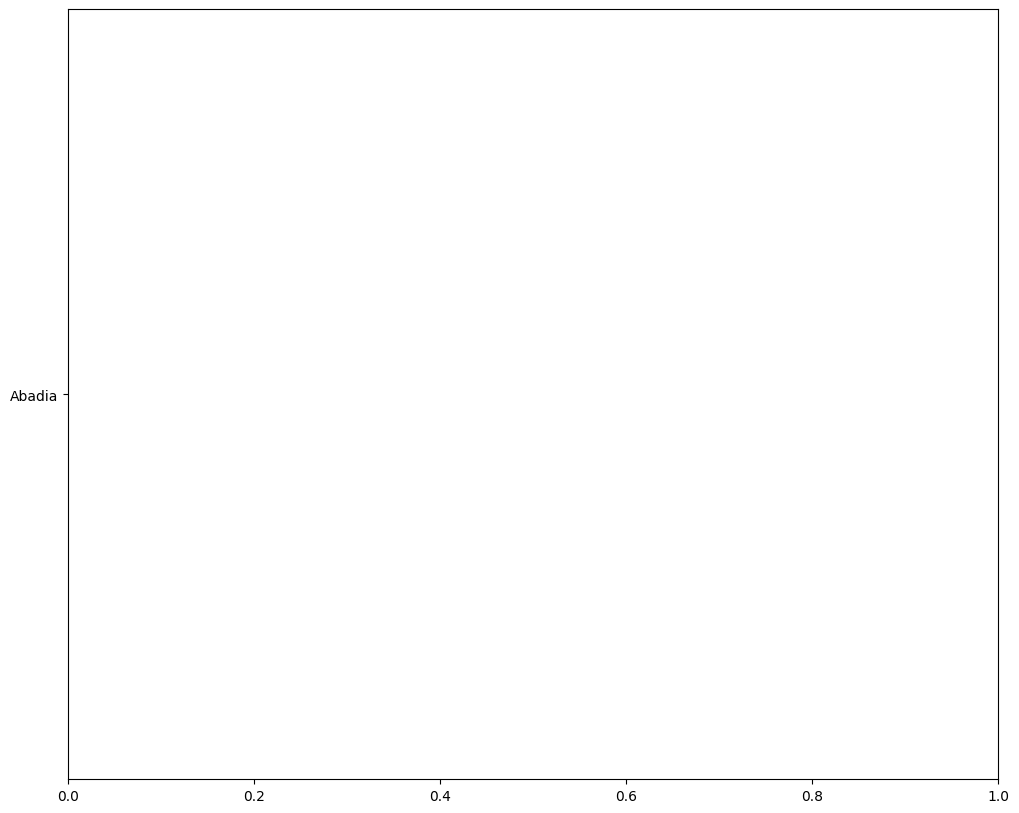

In [13]:
# Cell 5: Phase 4 - Refined Visualization (Style Fix)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd # Ensure pandas is imported

print("--- Phase 4: Refined Data Visualization ---")

# Ensure the combined metrics DataFrame exists and includes sentiment
if 'df_combined_metrics' in locals() and not df_combined_metrics.empty and 'avg_tweet_sentiment' in df_combined_metrics.columns:

    # --- Plot 1: Tweet Volume (Hype Proxy) ---
    # (Keep this plot the same as before)
    print("\nGenerating Plot 1: Tweet Volume by Brand...")
    plt.figure(figsize=(12, 10))
    df_sorted_hype = df_combined_metrics.sort_values('tweet_volume', ascending=False).head(30)
    sns.barplot(data=df_sorted_hype, y='brand_name', x='tweet_volume', palette='viridis')
    plt.title('Tweet Volume (Hype Proxy) by Brand (Top 30)')
    plt.xlabel('Total Tweets Collected')
    plt.ylabel('Brand')
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.savefig(os.path.join('..', 'tweet_volume_by_brand_v3.png'))
    print("   Saved plot as tweet_volume_by_brand_v3.png")
    plt.close()


    # --- Plot 2: Market Saturation ---
    # (Keep this plot the same as before)
    print("\nGenerating Plot 2: Market Saturation (Amazon Products) by Brand...")
    df_saturated = df_combined_metrics[df_combined_metrics['market_saturation'] > 0]
    if not df_saturated.empty:
        plt.figure(figsize=(12, 10))
        df_sorted_saturation = df_saturated.sort_values('market_saturation', ascending=False)
        sns.barplot(data=df_sorted_saturation, y='brand_name', x='market_saturation', palette='magma')
        plt.title('Market Saturation (Amazon Products Found) by Brand')
        plt.xlabel('Number of Products Found (Max 25)')
        plt.ylabel('Brand')
        plt.yticks(fontsize=8)
        plt.tight_layout()
        plt.savefig(os.path.join('..', 'market_saturation_by_brand_v3.png'))
        print("   Saved plot as market_saturation_by_brand_v3.png")
        plt.close()
    else:
        print("   Skipping Market Saturation plot: No brands with products found.")


    # --- Plot 3: Hype vs. Saturation Scatter Plot (Style Fix) ---
    print("\nGenerating Plot 3: Tweet Volume vs. Market Saturation...")
    plt.figure(figsize=(10, 8))
    df_plot_data = df_combined_metrics[(df_combined_metrics['market_saturation'] > 0) & (df_combined_metrics['tweet_volume'] > 0)].copy()

    if not df_plot_data.empty:
        # --- FIX: Create a categorical sentiment column ---
        def categorize_sentiment(score):
            if score >= 0.05: # Threshold for positive
                return 'Positive'
            elif score <= -0.05: # Threshold for negative
                return 'Negative'
            else:
                return 'Neutral'

        df_plot_data['sentiment_category'] = df_plot_data['avg_tweet_sentiment'].apply(categorize_sentiment)
        # --- End Fix ---

        scatter = sns.scatterplot(
            data=df_plot_data,
            x='market_saturation',
            y='tweet_volume',
            hue='avg_perceived_quality',
            size='avg_num_reviews',
            style='sentiment_category', # *** USE THE NEW CATEGORICAL COLUMN ***
            style_order=['Positive', 'Neutral', 'Negative'], # Order remains the same
            markers={'Positive': 'P', 'Neutral': 'o', 'Negative': 'X'}, # Markers remain the same
            sizes=(50, 600),
            palette='coolwarm',
            legend='auto'
        )

        # Add labels (Keep as before)
        for i in range(df_plot_data.shape[0]):
            plt.text(
                x=df_plot_data['market_saturation'].iloc[i] + 0.15,
                y=df_plot_data['tweet_volume'].iloc[i] + 10,
                s=df_plot_data['brand_name'].iloc[i],
                fontdict=dict(color='black', size=8)
            )

        plt.title('Hype (Tweet Volume) vs. Market Saturation')
        plt.xlabel('Market Saturation (Amazon Products)')
        plt.ylabel('Tweet Volume (Total Tweets)')

        # Add quadrant lines (Keep as before)
        median_hype = df_plot_data['tweet_volume'].median()
        median_saturation = df_plot_data['market_saturation'].median()
        if pd.notna(median_hype): plt.axhline(median_hype, color='grey', linestyle='--', linewidth=0.8)
        if pd.notna(median_saturation): plt.axvline(median_saturation, color='grey', linestyle='--', linewidth=0.8)

        plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.tight_layout(rect=[0, 0, 0.85, 1])
        plt.savefig(os.path.join('..', 'hype_vs_saturation_v3.png')) # Overwrite previous v3
        print("   Saved plot as hype_vs_saturation_v3.png")
        plt.close()
    else:
         print("   Skipping Hype vs. Saturation plot: No brands with both products and tweets found.")

    # --- Plot 4: Average Tweet Sentiment ---
    # (Keep this plot the same as before)
    print("\nGenerating Plot 4: Average Tweet Sentiment by Brand...")
    plt.figure(figsize=(12, 10))
    df_sorted_sentiment = df_combined_metrics.sort_values('avg_tweet_sentiment', ascending=False)
    # Define colors based on sentiment category
    sentiment_colors = {'Positive': 'green', 'Neutral': 'grey', 'Negative': 'red'}
    # Apply categorize function to main df for coloring this plot too
    df_sorted_sentiment['sentiment_category'] = df_sorted_sentiment['avg_tweet_sentiment'].apply(categorize_sentiment)
    bar_colors = df_sorted_sentiment['sentiment_category'].map(sentiment_colors)

    barplot_sentiment = sns.barplot(
        data=df_sorted_sentiment,
        y='brand_name',
        x='avg_tweet_sentiment',
        palette=bar_colors # Use mapped colors
    )
    plt.title('Average Tweet Sentiment by Brand (VADER Compound Score)')
    plt.xlabel('Average Sentiment (-1 Negative to +1 Positive)')
    plt.ylabel('Brand')
    plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.savefig(os.path.join('..', 'avg_tweet_sentiment_by_brand_v3.png')) # Overwrite previous v3
    print("   Saved plot as avg_tweet_sentiment_by_brand_v3.png")
    plt.close()


    print("\n--- Visualization Complete ---")

else:
    print("   ERROR: 'df_combined_metrics' DataFrame not found or empty, or missing 'avg_tweet_sentiment'. Cannot create plots.")

In [14]:
# Cell 5: Phase 4 - Refined Visualization (Palette Fix)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd # Ensure pandas is imported

print("--- Phase 4: Refined Data Visualization ---")

# Ensure the combined metrics DataFrame exists and includes sentiment
if 'df_combined_metrics' in locals() and not df_combined_metrics.empty and 'avg_tweet_sentiment' in df_combined_metrics.columns:

    # --- Plot 1: Tweet Volume (Hype Proxy) ---
    # (Keep this plot the same as before)
    print("\nGenerating Plot 1: Tweet Volume by Brand...")
    plt.figure(figsize=(12, 10))
    df_sorted_hype = df_combined_metrics.sort_values('tweet_volume', ascending=False).head(30)
    sns.barplot(data=df_sorted_hype, y='brand_name', x='tweet_volume', hue='brand_name', palette='viridis', legend=False) # Use hue trick
    plt.title('Tweet Volume (Hype Proxy) by Brand (Top 30)')
    plt.xlabel('Total Tweets Collected')
    plt.ylabel('Brand')
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.savefig(os.path.join('..', 'tweet_volume_by_brand_v3.png'))
    print("   Saved plot as tweet_volume_by_brand_v3.png")
    plt.close()


    # --- Plot 2: Market Saturation ---
    # (Keep this plot the same as before)
    print("\nGenerating Plot 2: Market Saturation (Amazon Products) by Brand...")
    df_saturated = df_combined_metrics[df_combined_metrics['market_saturation'] > 0]
    if not df_saturated.empty:
        plt.figure(figsize=(12, 10))
        df_sorted_saturation = df_saturated.sort_values('market_saturation', ascending=False)
        sns.barplot(data=df_sorted_saturation, y='brand_name', x='market_saturation', hue='brand_name', palette='magma', legend=False) # Use hue trick
        plt.title('Market Saturation (Amazon Products Found) by Brand')
        plt.xlabel('Number of Products Found (Max 25)')
        plt.ylabel('Brand')
        plt.yticks(fontsize=8)
        plt.tight_layout()
        plt.savefig(os.path.join('..', 'market_saturation_by_brand_v3.png'))
        print("   Saved plot as market_saturation_by_brand_v3.png")
        plt.close()
    else:
        print("   Skipping Market Saturation plot: No brands with products found.")


    # --- Plot 3: Hype vs. Saturation Scatter Plot ---
    # (Keep this plot the same as before - v2 fix)
    print("\nGenerating Plot 3: Tweet Volume vs. Market Saturation...")
    plt.figure(figsize=(10, 8))
    df_plot_data = df_combined_metrics[(df_combined_metrics['market_saturation'] > 0) & (df_combined_metrics['tweet_volume'] > 0)].copy()

    if not df_plot_data.empty:
        # Create a categorical sentiment column
        def categorize_sentiment(score):
            if score >= 0.05: return 'Positive'
            elif score <= -0.05: return 'Negative'
            else: return 'Neutral'
        df_plot_data['sentiment_category'] = df_plot_data['avg_tweet_sentiment'].apply(categorize_sentiment)

        scatter = sns.scatterplot(
            data=df_plot_data,
            x='market_saturation',
            y='tweet_volume',
            hue='avg_perceived_quality',
            size='avg_num_reviews',
            style='sentiment_category', # Use the categorical column
            style_order=['Positive', 'Neutral', 'Negative'],
            markers={'Positive': 'P', 'Neutral': 'o', 'Negative': 'X'},
            sizes=(50, 600),
            palette='coolwarm',
            legend='auto'
        )
        # Add labels
        for i in range(df_plot_data.shape[0]):
            plt.text(x=df_plot_data['market_saturation'].iloc[i] + 0.15,
                     y=df_plot_data['tweet_volume'].iloc[i] + 10,
                     s=df_plot_data['brand_name'].iloc[i],
                     fontdict=dict(color='black', size=8))

        plt.title('Hype (Tweet Volume) vs. Market Saturation')
        plt.xlabel('Market Saturation (Amazon Products)')
        plt.ylabel('Tweet Volume (Total Tweets)')
        # Add quadrant lines
        median_hype = df_plot_data['tweet_volume'].median()
        median_saturation = df_plot_data['market_saturation'].median()
        if pd.notna(median_hype): plt.axhline(median_hype, color='grey', linestyle='--', linewidth=0.8)
        if pd.notna(median_saturation): plt.axvline(median_saturation, color='grey', linestyle='--', linewidth=0.8)

        plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.tight_layout(rect=[0, 0, 0.85, 1])
        plt.savefig(os.path.join('..', 'hype_vs_saturation_v3.png'))
        print("   Saved plot as hype_vs_saturation_v3.png")
        plt.close()
    else:
         print("   Skipping Hype vs. Saturation plot: No brands with both products and tweets found.")

    # --- Plot 4: Average Tweet Sentiment (Palette Fix) ---
    print("\nGenerating Plot 4: Average Tweet Sentiment by Brand...")
    plt.figure(figsize=(12, 10))
    df_sorted_sentiment = df_combined_metrics.sort_values('avg_tweet_sentiment', ascending=False)

    # --- FIX: Create a list of colors in the correct sorted order ---
    sentiment_colors_map = {'Positive': '#2ca02c', 'Neutral': '#8c8c8c', 'Negative': '#d62728'} # Green/Grey/Red
    # Apply categorize function if not already present from scatter plot section
    if 'sentiment_category' not in df_sorted_sentiment.columns:
         df_sorted_sentiment['sentiment_category'] = df_sorted_sentiment['avg_tweet_sentiment'].apply(categorize_sentiment)
    # Create the list of colors based on the sorted data
    bar_colors_list = df_sorted_sentiment['sentiment_category'].map(sentiment_colors_map).tolist()
    # --- End Fix ---

    barplot_sentiment = sns.barplot(
        data=df_sorted_sentiment,
        y='brand_name',
        x='avg_tweet_sentiment',
        palette=bar_colors_list # *** USE THE LIST OF COLORS ***
        # hue='brand_name', # Alt: Could map category to hue, but less direct color control
        # legend=False
    )
    plt.title('Average Tweet Sentiment by Brand (VADER Compound Score)')
    plt.xlabel('Average Sentiment (-1 Negative to +1 Positive)')
    plt.ylabel('Brand')
    plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.savefig(os.path.join('..', 'avg_tweet_sentiment_by_brand_v3.png'))
    print("   Saved plot as avg_tweet_sentiment_by_brand_v3.png")
    plt.close()


    print("\n--- Visualization Complete ---")

else:
    print("   ERROR: 'df_combined_metrics' DataFrame not found or empty, or missing 'avg_tweet_sentiment'. Cannot create plots.")

--- Phase 4: Refined Data Visualization ---

Generating Plot 1: Tweet Volume by Brand...
   Saved plot as tweet_volume_by_brand_v3.png

Generating Plot 2: Market Saturation (Amazon Products) by Brand...
   Saved plot as market_saturation_by_brand_v3.png

Generating Plot 3: Tweet Volume vs. Market Saturation...
   Saved plot as hype_vs_saturation_v3.png

Generating Plot 4: Average Tweet Sentiment by Brand...


C:\Users\Nayef Alam\AppData\Local\Temp\ipykernel_15664\1281034600.py:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot_sentiment = sns.barplot(


   Saved plot as avg_tweet_sentiment_by_brand_v3.png

--- Visualization Complete ---


In [15]:
# Cell 6: Save Final Metrics to CSV

import os
import pandas as pd # Ensure pandas is imported

print("\n--- Saving Final Combined Metrics (with Sentiment) ---")

# Ensure the DataFrame exists
if 'df_combined_metrics' in locals() and not df_combined_metrics.empty:
    # Define the output path
    csv_path_relative = os.path.join('..', 'data', 'brand_metrics_final_v2.csv') # New filename
    csv_path = os.path.abspath(csv_path_relative)
    
    try:
        # Save to CSV, excluding the index
        df_combined_metrics.to_csv(csv_path, index=False)
        print(f"   Successfully saved final metrics to: {csv_path}")
    except Exception as e:
        print(f"   Error saving metrics to CSV: {e}")
else:
    print("   ERROR: 'df_combined_metrics' not found or empty. Cannot save.")


--- Saving Final Combined Metrics (with Sentiment) ---
   Successfully saved final metrics to: c:\Users\Nayef Alam\Desktop\ksa_licensing_model\data\brand_metrics_final_v2.csv
